# Credit Anxiety Index

Ovaj indeks kombinira objektivne tržišne podatke s psihološkim indikatorima kako bi detektirao **rane znakove ekonomskog usporavanja**.

## Što je Credit Anxiety Index?

Indeks koji mjeri ***financijsku napetost*** na tržištu kombiniranjem kreditnog spreada i javnog interesa.

- **Kreditni spread** — razlika između prinosa na rizične i sigurne obveznice
- **Javni interes** — koliko ljudi aktivno traži informacije o kreditnim problemima

## Zašto je važan?
Tijekom ekonomskih kriza investitori postaju oprezni, zahtijevaju veću premiju za rizik, a javnost aktivno traži informacije o financijskim problemima.

## Što je premija za rizik?

**Premija za rizik** = dodatni prinos koji investitori zahtijevaju.

### Primjer

| Vrsta obveznice | Prinos | Rizik |
|----------------|--------|-------|
| **Državne obveznice** (GS10) | 4% | Nisko - jamči vlada |
| **Korporativne obveznice** (DBAA) | 6% | Visoko - ovisi o korporaciji |
| **Premija za rizik** | **2%** | Razlika = naknada za rizik |

### Kako radi:

Investitor kaže: *"OK, kupujem ovu rizičniju korporativnu obveznicu, ali zahtijevam **2% više** kao naknadu za rizik da korporacija možda neće vratiti novac."*

### Dinamika premije

**Kad se ekonomija pogoršava:**
- Veći rizik bankrota korporacija
- Investitori traže veću premiju
- **Spread raste** (npr. s 2% na 4%)

**Kad je stabilno:**
- Manji rizik
- Manja premija
- **Spread pada** (npr. s 4% natrag na 2%)

### U kontekstu Credit Anxiety Index-a
```
Credit Spread = DBAA - GS10 = Premija za kreditni rizik
```


In [64]:
import urllib.request
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from pytrends.request import TrendReq

warnings.filterwarnings("ignore", category=FutureWarning)

today = pd.Timestamp('today').normalize()


### Skidanje podataka

**FRED (Federal Reserve Economic Data)** je baza podataka Federalnih rezervi SAD-a koja sadrži tisuće ekonomskih vremenskih serija.

### Preuzimamo:
- **GS10** - 10-godišnje državne obveznice SAD-a (Treasury)
- **DBAA** - Moody's Seasoned Baa Corporate Bond Yield


In [65]:
today_str = dt.date.today().strftime("%Y-%m-%d")

url_dbaa = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id=DBAA&cosd=2020-01-01&coed={today_str}"
url_gs10 = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id=GS10&cosd=2020-01-01&coed={today_str}"

_=urllib.request.urlretrieve(url_dbaa, "DBAA.csv")
_=urllib.request.urlretrieve(url_gs10, "GS10.csv")


### GS10 (10-Year Treasury)
- Zlatni standard "bezrizične" investicije
- Jamči ih američka vlada
- Tijekom kriza investitori bježe u sigurnost, prinos pada


### DBAA (Baa Corporate Bonds)
- Obveznice korporacija s **nižim kreditnim rejtingom** (Baa/BBB)
- Smatraju se **rizičnijima** od državnih obveznica
- Kad ekonomija slabi investitori traže veću premiju za preuzimanje rizika, prinos raste

In [66]:
dbaa = (pd.read_csv("DBAA.csv",
                    parse_dates=['observation_date'],
                    date_format='%m/%d/%y')  
          .rename(columns={'DBAA':'rate'}))

gs10 = (pd.read_csv("GS10.csv",
                    parse_dates=['observation_date'],
                    date_format='%m/%d/%y')
          .rename(columns={'GS10':'rate'}))

# zadnji dostupni dan
r_dbaa = dbaa.dropna().iloc[-1]
r_gs10 = gs10.dropna().iloc[-1]

spread = float(r_dbaa.rate) - float(r_gs10.rate)
print(f"DBAA: {r_dbaa.rate} % | GS10: {r_gs10.rate} % | Spread: {spread:.2f} %")

DBAA: 5.84 % | GS10: 4.06 % | Spread: 1.78 %


### Što je Credit Spread?

#### Credit Spread = DBAA - GS10

**Spread pokazuje premiju za kreditni rizik:**

| Spread | Status | Opis |
|--------|--------|------|
| **~1-2%** | Nizak | Investitori opušteni, spremni preuzeti rizik, ekonomija stabilna |
| **2-3%** | Umjeren | Povećana opreznost, prva zabrinutost oko kreditne sposobnosti |
| **>4%** | Visok | Panika, investitori bježe iz rizičnih obveznica, mogući znaci recesije |

**Povijesni kontekst:**
- **Normalna vremena (2015-2019)**: ~2%
- **COVID kriza (ožujak 2020)**: ~4%
- **Financijska kriza (2008-2009)**: ~6%

**Zašto se spread širi tijekom kriza?**

Kad ekonomija slabi:
1. Korporacije imaju veću vjerojatnost bankrota → investitori prodaju korporativne obveznice → DBAA raste
2. Investitori traže sigurnost → kupuju Treasury obveznice → GS10 pada
3. **Rezultat**: Spread eksplodira


In [67]:
#pip install pytrends 


### Dohvaćanje Google Trends podataka

Pratimo koliko ljudi traži termin *"credit crunch"* - indikator javne zabrinutosti.

**Zašto mjerimo javni interes za "credit crunch"?**

**Credit crunch** = situacija kada banke naglo smanjuju dostupnost kredita

### Psihologija tržišta:
- Kad ekonomija krene nizbrdo, ljudi počinju googlati "credit crunch", "recession", "layoffs"
- **Rast pretraga = rast zabrinutosti** = mogući rani signal problema
- Ponekad javnost osjeća probleme **prije nego se pojave u službenim podacima**

### Google Trends scoring:

| Vrijednost | Status |
|------------|--------|
| **<20** | Niska zabrinutost |
| **20-50** | Umjerena zabrinutost |
| **>50** | Visoka zabrinutost, nešto se događa |

**Zašto 3 mjeseca?**  
`timeframe='today 3-m'` je dovoljno kratko za hvatanje trendova, dovoljno dugo za izbjegavanje šuma.


In [68]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [69]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(["credit crunch"], timeframe='today 3-m')
trend_df = pytrends.interest_over_time()
gt = trend_df["credit crunch"].iloc[-1]
print("Google Trends:", gt)

Google Trends: 26


### Izračun Anxiety Index

Kombiniramo kreditni spread i javni interes:

#### Formula
```
Anxiety Index = Credit Spread + (Google Trends / 100)
```

- *Credit Spread*: Objektivna mjera tržišnog rizika
- *Google Trends*: Subjektivna mjera javne percepcije


**Zašto ova kombinacija?**

| Komponenta | Tip | Težina | Opis |
|------------|-----|--------|------|
| **Credit Spread** | Objektivna | ~1.5-6 bodova | Temelji se na stvarnim tržišnim transakcijama |
| **Google Trends / 100** | Subjektivna | ~0.2-1 bod | Hvata psihološke trendove i percepciju |

**Primjer:**
- Spread = 2.5%
- Google Trends = 40
- **Index = 2.5 + 0.4 = 2.9** → Umjerena napetost

In [70]:
index = spread + gt/100
row   = pd.DataFrame([{"observation_date": today, "dbaa": r_dbaa.rate, "gs10": r_gs10.rate,
                       "spread": spread, "gtrend": gt, "anxiety_index": index}])


### Spremanje i vizualizacija

Dodajemo novi podatak i prikazujemo trend.

In [71]:
try: hist = pd.read_csv("anxiety.csv", parse_dates=["observation_date"])
except: hist = pd.DataFrame()
hist  = pd.concat([hist, row]).drop_duplicates(subset=["observation_date"])
hist.to_csv("anxiety.csv", index=False)
print("Zadnji index:", round(index,2))

Zadnji index: 2.04


## Interpretacija rezultata


| Index | Status | Ekonomska situacija |
|-------|--------|---------------------|
| **< 2** | **Mirno tržište** | Stabilna ekonomija, niska premija za rizik, investitori opušteni |
| **2-4** | **Umjerena napetost** | Povećana opreznost, prva zabrinutost, krediti skupi |
| **> 4** | **Visok stres** | Ozbiljna kriza, investitori u panici, mogući signal recesije |

### Što znači rast indexa?

**Za korporacije:**
- Skuplje zaduživanje → manje investicija
- Otežan pristup kapitalu → usporavanje poslovanja
- Manji profit → moguća otpuštanja

**Za investitore:**
- "Flight to quality" → bijeg u sigurne obveznice
- Veća volatilnost tržišta
- Panične prodaje rizičnih imovina

**Za ekonomiju:**
- Rani znak usporavanja prije nego se pojavi u BDP-u
- Smanjenje kreditiranja → manje potrošnje
- Samoostvarujuće proročanstvo: strah → manje investicija → recesija

### Povijesni kontekst

| Događaj | Spread | Index | Ishod |
|---------|--------|-------|-------|
| **2008 Financijska kriza** | ~6% | ~6.5 | Teška recesija |
| **2020 COVID** | ~4% | ~4.3 | Brz oporavak uz Fed intervenciju |
| **2024 Trenutno** | ~2% | ~2 | Relativno mirno |  

</br>



> **Napomena**: Pragovi su indikativni. Za točnije granice potrebna je analiza 
> povijesnih recesija (2008, 2020) i usporedba sa stvarnim ekonomskim događajima.

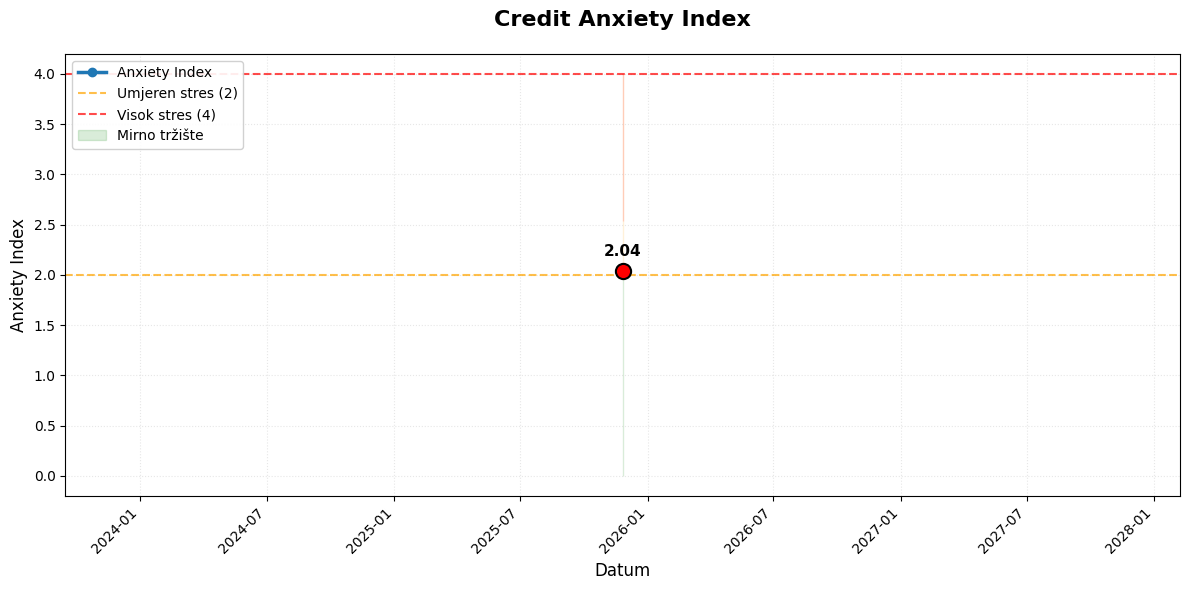

In [76]:
fig, ax = plt.subplots(figsize=(12, 6))

# glavna linija
ax.plot(hist['observation_date'], hist['anxiety_index'], 
        marker='o', linewidth=2.5, markersize=6,
        color='#1f77b4', label='Anxiety Index')

# threshold linije
ax.axhline(y=2, color='orange', linestyle='--', linewidth=1.5, 
           alpha=0.7, label='Umjeren stres (2)')
ax.axhline(y=4, color='red', linestyle='--', linewidth=1.5, 
           alpha=0.7, label='Visok stres (4)')

# bojanje zona
max_idx = hist['anxiety_index'].max()
ax.fill_between(hist['observation_date'], 0, 2, 
                alpha=0.15, color='green', label='Mirno tržište')
ax.fill_between(hist['observation_date'], 2, 4, 
                alpha=0.15, color='orange')
ax.fill_between(hist['observation_date'], 4, max_idx + 0.5, 
                alpha=0.15, color='red')

# Označi zadnju vrijednost
last_date = hist['observation_date'].iloc[-1]
last_val = hist['anxiety_index'].iloc[-1]
ax.scatter(last_date, last_val, s=120, color='red', 
           zorder=5, edgecolor='black', linewidth=1.5)
ax.text(last_date, last_val + 0.15, f'{last_val:.2f}', 
        ha='center', fontsize=11, fontweight='bold')

# Styling
ax.set_title('Credit Anxiety Index', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Datum', fontsize=12)
ax.set_ylabel('Anxiety Index', fontsize=12)
ax.legend(loc='upper left', framealpha=0.9)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.8)

# Rotacija x-osi
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("anxiety.png", dpi=150, bbox_inches='tight')
plt.show()